In [87]:
! pip install mysql-connector-python

In [88]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import matplotlib
from matplotlib import pyplot as plt
from nltk.classify import NaiveBayesClassifier
from nltk.classify.util import accuracy as nltk_accuracy

import mysql.connector
from mysql.connector import Error
# import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [89]:
connection = mysql.connector.connect(
        host='ds50-mysql-do-user-9644544-0.b.db.ondigitalocean.com',
        database='ds50',
        user='ds50',
        password='AVNS_4ybSd0CoPKnCL5F',
        port = '25060')
if connection.is_connected():
        data = pd.read_sql( '''SELECT * FROM REVIEW LIMIT 5000 
        ''', connection)
        connection.close()
data=pd.DataFrame(data)


C:\Users\antoi\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [90]:
data.head(50)


,review_id,user_id,book_id,rating,review_text,date_added,started_at,n_votes,n_comments
0,0000070d5b02a290c631438f4f618c48,644915,2318271,5,"Meski sudah banyak orang tahu buku ini, namun ...",2010-05-13 13:04:33,NaT,0,0
1,00000dd80b43a2cf2afee588cfdd72e2,141599,28954189,5,Death can be cured and aging reversed. The nee...,2017-02-16 19:00:04,2017-03-24 07:00:00,0,0
2,00001391db9e5a03e3f13da55399d427,157659,16043719,2,The Marriage Mistake focuses on Count's younge...,2012-11-30 03:45:25,2012-12-18 08:00:00,0,0
3,00001da050362c5a7eaf6a0614385a29,184748,15507958,5,When I saw the trailer for the movie version o...,2016-08-17 13:31:06,2016-07-27 07:00:00,0,0
4,00002061af3a9f981f601d7f223a6b35,154981,12578313,4,I didn't expect to enjoy this as much as I did...,2013-12-02 21:27:56,NaT,0,0
5,0000271000ca3f0ed54ec992fa502672,57501,13418329,5,In 1999 a friend of mine suggested I read this...,2013-09-07 19:49:37,2017-05-03 07:00:00,0,0
6,00002956a602b00f44b4d2e42eec50b8,105694,15283043,5,This is one of the very few books that I loved...,2013-07-13 15:49:37,NaT,0,0
7,00002e84abd11229f94cad76a601f288,395328,4588,5,Made me cry on the subway- but in a really goo...,2007-12-27 00:57:37,NaT,0,0
8,000039a2fc73f37e615c4acc4498116a,218600,12444166,5,What an awesome read. So kicking myself for pu...,2012-03-29 23:07:35,2013-03-26 07:00:00,1,0
9,00004fead2419af82ee3c84b533dea27,256390,2743,5,I read this many years ago and I still talk ab...,2010-07-27 03:28:05,NaT,0,0


In [91]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   review_id    5000 non-null   object        
 1   user_id      5000 non-null   int64         
 2   book_id      5000 non-null   int64         
 3   rating       5000 non-null   int64         
 4   review_text  5000 non-null   object        
 5   date_added   5000 non-null   datetime64[ns]
 6   started_at   3000 non-null   datetime64[ns]
 7   n_votes      5000 non-null   int64         
 8   n_comments   5000 non-null   int64         
dtypes: datetime64[ns](2), int64(5), object(2)
memory usage: 351.7+ KB


In [92]:
data = data[(data['review_text'].str.len() > 3) & (data['review_text'].str.len() < 3000) & (((~ data['review_text'].str.isdigit()) & (data['review_text'].str.len() != 0)) | (data['rating'] != 0))]


In [93]:
data.shape

(4822, 9)

In [94]:
def isfloat(num):
    try:
        float(num)
        return True
    except ValueError:
        return False


In [106]:
import re  
import nltk
nltk.download('stopwords')
 
# to remove stopword
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

# for Stemming propose
from nltk.stem.porter import PorterStemmer
corpus = []

def remove_punctuation(text):
    import string
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

for i in range(0, len(data)):
    if data['review_text'].iloc[i].isdigit() or isfloat(data['review_text'].iloc[i]):
        if float(data['review_text'].iloc[i])>=0 and float(data['review_text'].iloc[i])<= 1:
            data['review_text'].iloc[i]="bad"
        elif float(data['review_text'].iloc[i])>1 and float(data['review_text'].iloc[i])<= 2:
            data['review_text'].iloc[i]="not bad"
        elif float(data['review_text'].iloc[i])>2 and float(data['review_text'].iloc[i])<= 3:
            data['review_text'].iloc[i]="average"
        elif float(data['review_text'].iloc[i])>3 and float(data['review_text'].iloc[i])<= 4:
            data['review_text'].iloc[i]="good"
        elif float(data['review_text'].iloc[i])>4 and float(data['review_text'].iloc[i])<= 5:
            data['review_text'].iloc[i]="very good"
        else:
            #si c'est supérieur à 5, on mets le commentaire en fonction de la note attribué
            #print(f"nous sommes ligne {i} et le rating et {data['rating'].iloc[i]}")
            match int(data['rating'].iloc[i]):
                case 1:
                    data['review_text'].iloc[i]="bad"
                case 2:
                    data['review_text'].iloc[i]="not bad"
                case 3:
                    data['review_text'].iloc[i]="average"
                case 4:
                    data['review_text'].iloc[i]="good"
                case 5:
                    data['review_text'].iloc[i]="very good"
    elif len(data['review_text'].iloc[i]) == 0:
        #si c'est vide, on mets le commentaire en fonction de la note attribué
        print(f"nous sommes ligne {i} et le rating et {data['rating'].iloc[i]}")
        match int(data['rating'].iloc[i]):
            case 1:
                data['review_text'].iloc[i]="bad"
            case 2:
                data['review_text'].iloc[i]="not bad"
            case 3:
                data['review_text'].iloc[i]="average"
            case 4:
                data['review_text'].iloc[i]="good"
            case 5:
                data['review_text'].iloc[i]="very good"         
    else : 
        review = remove_punctuation(data['review_text'].iloc[i])

        # convert all cases to lower cases
        review = review.lower()

        # split to array(default delimiter is " ")
        review = review.split()

        # creating PorterStemmer object to
        # take main stem of each word
        ps = PorterStemmer()

        # loop for stemming each word
        # in string array at ith row   
        review = [ps.stem(word) for word in review
                    if not word in set(stopwords.words('english'))]

        # rejoin all string array elements
        # to create back into a string
        review = ' '.join(review) 

        # append each string to create
        # array of clean text
        corpus.append(review)
        data['review_text'].iloc[i]=review

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\antoi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\antoi\AppData\Local\Temp\ipykernel_14728\3733990068.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['review_text'].iloc[i]=review


nous sommes ligne 1372 et le rating et 2


C:\Users\antoi\AppData\Local\Temp\ipykernel_14728\3733990068.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['review_text'].iloc[i]="not bad"
C:\Users\antoi\AppData\Local\Temp\ipykernel_14728\3733990068.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['review_text'].iloc[i]="average"
C:\Users\antoi\AppData\Local\Temp\ipykernel_14728\3733990068.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['review_text'].i

****Translate****

In [58]:
!pip install -U deep-translator

In [59]:
!pip install langdetect

In [108]:
print(data.loc[1372,"review_text"])

not bad


In [109]:
from langdetect import detect 
from deep_translator import GoogleTranslator

try:
    data = data.reset_index()
except Exception:
    print("jeu de données déjà réindexé")

for i in range(0, len(data)):                            

    texte=data['review_text'].iloc[i]
    
    try:
        temp = detect(texte)
    except Exception as lde:
        print(f"Nous sommes ligne : {i}")

    if (len(texte) != 0 and not texte.isspace())and detect(texte)!="en":
        translated = GoogleTranslator(source='auto', target='en').translate(text=texte)
        data['review_text'].iloc[i]== translated

data.head()

**Ratings count**

<AxesSubplot:xlabel='rating', ylabel='count'>

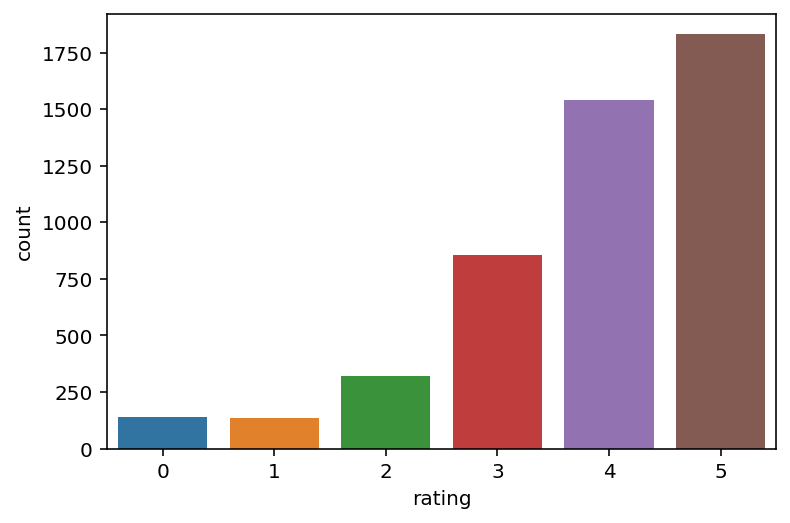

In [26]:
import seaborn as sns
sns.countplot(x=data['rating'],data=data)

In [ ]:
ratings_equal_zero=data[data['rating']==0]


In [ ]:
data=data[['review_id', 'rating', 'review_text']]
data.head()

In [ ]:
rate_id_one = []
rate_id_two = []
rate_id_three = []
rate_id_four = []
rate_id_five =[]


for review_text, rating in zip(data['review_text'], data['rating']):
    line = review_text.split(" ")
    dic = {}
    if rating == 1:
        for word in line:
            dic[word] = True
        ireru = (dic, 1)
        rate_id_one.append(ireru)
    elif rating == 2:
        for word in line:
            dic[word] = True
        ireru = (dic, 2)
        rate_id_two.append(ireru) 
    elif rating == 3:
        for word in line:
            dic[word] = True
        ireru = (dic, 3)
        rate_id_three.append(ireru)
    elif rating == 4:
        for word in line:
            dic[word] = True
        ireru = (dic, 4)
        rate_id_four.append(ireru)
    else:
        for word in line:
            dic[word] = True
        ireru = (dic, 5)
        rate_id_five.append(ireru)


In [ ]:
threshold = 0.8
num_one = int(threshold * len(rate_id_one))
num_two = int(threshold * len(rate_id_two))
num_three = int(threshold * len(rate_id_three))
num_four = int(threshold * len(rate_id_four))
num_five = int(threshold * len(rate_id_five))

features_train = rate_id_one[:num_one] + rate_id_two[:num_two] + rate_id_three[:num_three] + rate_id_four[:num_four] + rate_id_five[:num_five]
features_test = rate_id_one[num_one:] + rate_id_two[num_two:] + rate_id_three[num_three:] + rate_id_four[num_four:] + rate_id_five[num_five:]
print("Number of training datapoints:", len(features_train))
print("Number of test datapoints:", len(features_test))

In [ ]:
classifier = NaiveBayesClassifier.train(features_train)
print('Accuracy of the classifier:', nltk_accuracy(classifier, features_test))

The cause may be that there is a wide range of choices from 1 to 5 and that the absolute number of low-rated sentence data is insufficient. For example, if you choose between 1 and 5 rates, it may improve.

Alternatively, if other methods are used, the accuracy may be further improved, so this will be an issue for the future.

words influenced the predicted numbers during the training.

In [ ]:
N = 30
print('Top ' + str(N) + ' most informative words:')
for i, item in enumerate(classifier.most_informative_features()[:N]):
    print(str(i+1) + '. ' + item[0]) 

In [ ]:
def extract_features(words):
    return dict([(word, True) for word in words])
#Divide into words like the large amount of review text earlier


print("Clothes review predictions:")

 
for i in range(0, len(data)):
    if data['rating'].iloc[i]==0 :
        input_review = data['review_text'].iloc[i]
        features = extract_features(input_review.split())
        probabilities = classifier.prob_classify(features)
        predicted_sentiment = probabilities.max()
        data['rating'].iloc[i]=predicted_sentiment
        

In [ ]:
ratings_equal_zero = data[data['rating']==0] 
ratings_equal_zero.head()

there is no ratings equal to 0

In [ ]:
data.head(30)